In [1]:
# %matplotlib inline 


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


Selected checkpoint: trainings/AAPL_0.09436_fin.pth

Hyperparameters:
{'ALPHA_SMOOTH': 0.0,
 'CLIPNORM': 3,
 'CONV_CHANNELS': 64,
 'CONV_DILATION': 1,
 'CONV_K': 3,
 'DROPOUT_LONG': 0.2,
 'DROPOUT_SHORT': 0.2,
 'DROPOUT_TRANS': 0.05,
 'EARLY_STOP_PATIENCE': 9,
 'FLATTEN_MODE': 'attn',
 'HEAD_LR_PCT': 1,
 'HUBER_DELTA': 0.1,
 'LAMBDA_DELTA': 0.1,
 'LONG_UNITS': 128,
 'LOOK_BACK': 60,
 'MAX_EPOCHS': 90,
 'MICRO_SAMPLE_K': 16,
 'ONECYCLE_DIV_FACTOR': 10,
 'ONECYCLE_FINAL_DIV': 100,
 'ONECYCLE_MAX_LR': 0.0003,
 'ONECYCLE_PCT_START': 0.1,
 'ONECYCLE_STRATEGY': 'cos',
 'PRED_HIDDEN': 128,
 'SHORT_UNITS': 96,
 'TCN_CHANNELS': 64,
 'TCN_KERNEL': 3,
 'TCN_LAYERS': 3,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 4,
 'TRAIN_WORKERS': 8,
 'TRANSFORMER_D_MODEL': 64,
 'TRANSFORMER_FF_MULT': 4,
 'TRANSFORMER_HEADS': 4,
 'TRANSFORMER_LAYERS': 4,
 'USE_CONV': False,
 'USE_DELTA': False,
 'USE_HUBER': False,
 'USE_LONG_LSTM': False,
 'USE_SHORT_LSTM': False,
 'USE_TCN': False,
 'USE_TRANSFORMER': True,

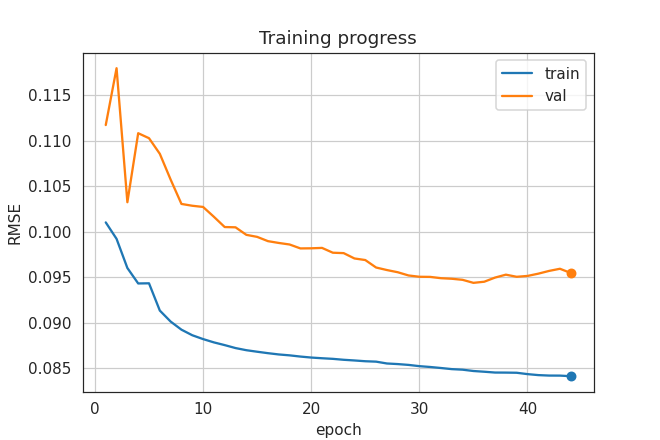


Train metrics: {'rmse': 0.0841025893636841, 'mae': 0.057105485026677796, 'r2': 0.288848726058061}
 Val metrics: {'rmse': 0.09544878796893021, 'mae': 0.0712841932703286, 'r2': 0.24122477963365763}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=70, out_features=70, bias=True)
  (feature_proj): Linear(in_features=70, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
     

In [3]:
fname = f"{params.ticker}_{params.sel_val_rmse}_fin.pth"
model_path = Path(params.models_folder) / fname

print("Selected checkpoint:", model_path)

# Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

model_feats = ckpt['features']
print("\nFeatures:")
pprint(model_feats)

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# Reinstantiate a *clean* model in CPU memory
model_choice = models_custom.ModelClass(
    n_feats             = len(model_feats),
    short_units         = ckpt["hparams"]["SHORT_UNITS"],
    long_units          = ckpt["hparams"]["LONG_UNITS"],
    transformer_d_model = ckpt["hparams"]["TRANSFORMER_D_MODEL"],
    transformer_layers  = ckpt["hparams"]["TRANSFORMER_LAYERS"],
    dropout_short       = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long        = ckpt["hparams"]["DROPOUT_LONG"],
    dropout_trans       = ckpt["hparams"]["DROPOUT_TRANS"],
    pred_hidden         = ckpt["hparams"]["PRED_HIDDEN"],
    look_back           = ckpt["hparams"]["LOOK_BACK"],

    # Gating flags
    use_conv            = ckpt["hparams"]["USE_CONV"],
    use_tcn             = ckpt["hparams"]["USE_TCN"],
    use_short_lstm      = ckpt["hparams"]["USE_SHORT_LSTM"],
    use_transformer     = ckpt["hparams"]["USE_TRANSFORMER"],
    use_long_lstm       = ckpt["hparams"]["USE_LONG_LSTM"],
    use_delta           = ckpt["hparams"]["USE_DELTA"],
    flatten_mode        = ckpt["hparams"]["FLATTEN_MODE"]
)

# Load *only* the weight tensors into that fresh model
model_choice.load_state_dict(ckpt["model_state_dict"])
model_choice.to(params.device)
model_choice.eval()

model_choice


In [4]:
df_model_feats = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[model_feats + ['close_raw'] + [params.label_col]]
    
df_model_feats

,dist_low_30,in_sess_time,dist_low_60,dist_low_28,eng_ema_cross_up,minute_time,rsi,hour_time,z_vwap_dev,dist_high_30,dist_high_60,eng_bb_mid,sma_pct_28,rsi_30,eng_vwap,plus_di,sma_pct_14,z_obv,adx_30,rsi_60,dist_high_28,roc_14,vwap_dev_pct_30,obv_diff_60,adx_60,volume_z_90,adx,z_vwap_dev_90,z_vwap_dev_60,obv_pct_14,minus_di,roc_28,obv_diff_14,obv_diff_30,vwap_dev_pct_60,plus_di_30,obv_pct_60,mom_sum_60,eng_macd,vwap_dev_pct_90,sma_pct_60,sma_pct_90,eng_ma,roc_30,obv_diff_90,obv_pct_30,vwap_dev_pct_z_90,volume_z_60,obv_z_90,obv_sma_90,adx_90,rsi_90,obv_pct_90,obv_sma_60,vwap_dev_pct_z_60,eng_obv,z_vwap_dev_30,ret_std_z_90,roc_60,atr_z_90,bb_w_z_90,macd_diff_z_60,obv_z_60,body_pct,vol_z_30,bb_w_z_60,minus_di_30,volume_z_30,macd_diff_z_90,plus_di_60,close_raw,signal
2009-01-02 11:02:00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.500425,0.000000,0.000000,0.488140,0.507099,1.000000,0.498899,0.000000,0.506758,0.725846,0.000000,1.000000,0.000000,0.499819,0.496075,0.570492,0.000000,0.500000,0.000000,0.497760,0.503264,1.000000,0.000000,0.504537,0.543793,0.556579,0.488882,0.000000,1.000000,0.505152,0.493704,0.491801,0.513064,0.512800,0.502857,0.504243,0.583952,1.000000,0.500000,0.411992,1.000000,0.285408,0.000000,1.000000,1.000000,0.303259,0.500000,0.798659,0.500929,0.500000,0.503281,0.304301,0.500000,0.500000,0.516862,0.489109,0.345224,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,4.056946e-07
2009-01-02 11:03:00,0.000000,0.0,0.000000,0.000000,0.0,0.001672,1.000000,0.0,0.500425,0.000000,0.000000,0.488140,0.507099,1.000000,0.498899,0.000000,0.506758,0.725846,0.000000,1.000000,0.000000,0.499819,0.496075,0.570492,0.000000,0.500000,0.000000,0.497760,0.503264,1.000000,0.000000,0.504537,0.543793,0.556579,0.488882,0.000000,1.000000,0.505152,0.493704,0.491801,0.513064,0.512800,0.502857,0.504243,0.583952,1.000000,0.500000,0.411992,1.000000,0.287735,0.000000,1.000000,1.000000,0.305367,0.500000,0.794979,0.500929,0.500000,0.503281,0.304301,0.500000,0.500000,0.516862,0.489109,0.345224,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,4.336628e-07
2009-01-02 11:04:00,0.000000,0.0,0.000000,0.000000,0.0,0.003345,1.000000,0.0,0.500425,0.000000,0.000000,0.488140,0.507099,1.000000,0.498899,0.000000,0.506758,0.725846,0.000000,1.000000,0.000000,0.499819,0.496075,0.570492,0.000000,0.500000,0.000000,0.497760,0.503264,1.000000,0.000000,0.504537,0.543793,0.556579,0.488882,0.000000,1.000000,0.505152,0.493704,0.491801,0.513064,0.512800,0.502857,0.504243,0.583952,1.000000,0.500000,0.411992,1.000000,0.290062,0.000000,1.000000,1.000000,0.307476,0.500000,0.791364,0.500929,0.500000,0.503281,0.304301,0.500000,0.500000,0.516862,0.489109,0.345224,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,4.635591e-07
2009-01-02 11:05:00,0.000000,0.0,0.000000,0.000000,0.0,0.005017,1.000000,0.0,0.500425,0.000000,0.000000,0.488140,0.507099,1.000000,0.498899,0.000000,0.506758,0.725846,0.000000,1.000000,0.000000,0.499819,0.496075,0.570492,0.000000,0.500000,0.000000,0.497760,0.503264,1.000000,0.000000,0.504537,0.543793,0.556579,0.488882,0.000000,1.000000,0.505152,0.493704,0.491801,0.513064,0.512800,0.502857,0.504243,0.583952,1.000000,0.500000,0.411992,1.000000,0.292389,0.000000,1.000000,1.000000,0.309585,0.500000,0.787813,0.500929,0.500000,0.503281,0.304301,0.500000,0.500000,0.516862,0.489109,0.345224,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,4.955165e-07
2009-01-02 11:06:00,0.000000,0.0,0.000000,0.000000,0.0,0.006689,1.000000,0.0,0.500425,0.000000,0.000000,0.488140,0.507099,1.000000,0.498899,0.000000,0.506758,0.725846,0.000000,1.000000,0.000000,0.499819,0.496075,0.570492,0.000000,0.500000,0.000000,0.497760,0.503264,1.000000,0.000000,0.504537,0.543793,0.556579,0.488882,0.000000,1.000000,0.505152,0.493704,0.491801,0.513064,0.512800,0.502857,0.504243,0.583952,1.000000,0.500000,0.411992,1.000000,0.294716,0.000000,1.000000,1.000000,0.311694,0.500000,0.784324,0.500929,0.500000,0.503281,0.304301,0.500000,0.500000,0.516862,0.489109,0.345224,0.500000

In [ ]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_model_feats,
    look_back       = params.hparams["LOOK_BACK"],
    sess_start      = params.sess_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh   = params.best_optuna_params["buy_threshold"],
    return_thresh   = 0 # TBI
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Preparing days:   0%|          | 0/4141 [00:00<?, ?it/s]

N_total: 1867591 look_back: 60 F: 70
Estimated X_buf size: 31.38 GB — using RAM (in-memory) (thresh 36 GiB)


Writing days:   0%|          | 0/4141 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 2912  (2009-01-02 → 2020-07-28)
 windows       : 1313312  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=70
 dataloader    : batches=182, batch_size=16, workers=8, pin_memory=True


In [ ]:
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])
y_test = np.concatenate([batch[1].cpu().numpy().ravel() for batch in test_loader])

# Visualize the true‐signal distributions on validation vs. test
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.hist(y_test, bins=100, alpha=0.5, label="test true")

plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Validation vs Test")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(models_custom)

print('Calculating Train metrics and predictions...')
train_metrics, _, train_preds, _, _ = \
    models_custom.eval_on_loader(train_loader, model_choice)

print('Calculating Val metrics and predictions...')
val_metrics, _, val_preds, _, _  = \
    models_custom.eval_on_loader(val_loader,   model_choice)

print('Calculating Test metrics and predictions...')
test_metrics, _, test_preds, _, _ = \
    models_custom.eval_on_loader(test_loader,  model_choice)


# Simple summary
print("=== SIMPLE SUMMARY ===\n")

print("Predictions lengths:")
print(f"  Train : {len(train_preds)}")
print(f"  Valid : {len(val_preds)}")
print(f"  Test  : {len(test_preds)}\n")

print("Metrics:")
print(f"  Train → RMSE={train_metrics['rmse']:.5f}, MAE={train_metrics['mae']:.5f}, R²={train_metrics['r2']:.5f}")
print(f"  Valid → RMSE={val_metrics['rmse']:.5f}, MAE={val_metrics['mae']:.5f}, R²={val_metrics['r2']:.5f}")
print(f"  Test  → RMSE={test_metrics['rmse']:.5f}, MAE={test_metrics['mae']:.5f}, R²={test_metrics['r2']:.5f}\n")

print("Predictions stats (mean±std):")
print(f"  Train : {train_preds.mean():.5f} ± {train_preds.std():.5f}")
print(f"  Valid : {val_preds.mean():.5f} ± {val_preds.std():.5f}")
print(f"  Test  : {test_preds.mean():.5f} ± {test_preds.std():.5f}")


In [ ]:
# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = models_custom.add_preds_and_split(
    df            = df_model_feats,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

# Create 'ask' and 'bid' columns using the given spread 
df_test['ask'] = round(df_test['close_raw'] * (1 + params.bidask_spread_pct/100), 4)
df_test['bid'] = round(df_test['close_raw'] * (1 - params.bidask_spread_pct/100), 4)

df_test

In [ ]:
# Quick correlation check
# This measures the absolute Pearson corr between each feature and the pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_raw")
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

In [ ]:
# Compute Descriptive Statistics
# Statistics show whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

In [ ]:
# pick a random day (normalized to midnight)
days = df_test.index.normalize().unique()
random_day = np.random.choice(days)
print("Selected day:", pd.to_datetime(random_day).date())

mask = df_test.index.normalize() == random_day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same random day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(params) ##########
importlib.reload(trades) ##########

# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.
# Simulate per‐day to avoid cross‐midnight state carry‐over
sim_results = {}

groups = list(df_test.groupby(df_test.index.normalize()))
print(f"Processing {len(groups)} days of predictions…")

for day, df_day in tqdm(groups, desc="Generate+Simulate"):
    # a) Generate discrete actions from the continuous signal
    df_actions = trades.generate_trade_actions(
        df                = df_day,
        col_signal        = "pred_signal", # name for the signal column to use
        col_action        = "pred_action", # name for the trade-action column to add
        sell_minidx       = -2,            # at what minute we sell and exit the trade
        buy_threshold     = params.sign_thresh_tick,
        trail_stop_pct    = params.trail_stop_tick,
        sess_start        = params.sess_start
    )

    # b) Run the backtest on this single‐day DataFrame
    single_result = trades.simulate_trading(
        results_by_day_sign = {day: (df_actions, [])},
        col_action          = "pred_action",
        sess_start          = params.sess_start,
        sess_end            = params.sess_end
    )
    sim_results.update(single_result)

# final: sim_results holds each day → (df_sim, trades, stats)


In [ ]:
importlib.reload(plots) ##########

year, month = map(int, params.month_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

model_feats = [f for f in df_model_feats.columns if f not in ('bid', 'ask', params.label_col)]

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {params.month_to_check}")
else:
    print(f"\nPlotting days in {params.month_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.sign_thresh_tick,
            performance_stats = perf_stats,
            col_close         = 'close_raw',
            col_bid           = 'bid',
            col_ask           = 'ask',
            col_trailstop     = 'trailstop_price',
            features          = model_feats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")
        print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == params.month_to_check]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)

In [ ]:
# 2) Persist CSVs

print("Saving test CSV…")
df_test.to_csv(params.test_csv)

print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)